In [1]:
# This jupyter notebook is for UNSW COMP9517
# Assignment 01 Cell Detection

In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
# This function is to implement Otsu algorithm
# STEP 1 Compute histogram and probabilities of each intensity pixel
# STEP 2 Setup initial w0 and u0
# STEP 3 Step through all possible thresholds t=1,...maximum intensity
#           a. Update wi and ui b. Compute 𝜎
# STEP 4 Desired threshold corresponds to the maximum 𝜎


def Otsu(image_name):
    # Read the image from the dir
    image = cv2.imread(image_name,0)
    # STEP 1: calculating the histogram 
    frequency_vector = [0 for i in range(0,256)]
    frequency_vector = np.array(frequency_vector)
    # test the type of the list
    # print(type(frequency_vector))
    row = image.shape[0]
    col = image.shape[1]
    for r in range(row):
        for c in range(col):
            point_value = image[r,c]
            frequency_vector[point_value] += 1
    
    total_pixels = row * col
    # The value of the pixel is 0 ----> get the value
    # pixel_value which is 0 is the foreground
    # pixel_value which is not 0 is the background
    foreground_pixel = frequency_vector[0]
    background_pixel = total_pixels - foreground_pixel

    # initialize the size
    foreground_pixel_total_value = 0 
    background_pixel_total_value = 0

    for index in range(0,256,1):
        # This step is to do the Statistics
        # Getting the background total pixel value
        # Source: https://en.wikipedia.org/wiki/Histogram
        # adding the value which is value i * frequency i is just like a kind of weighted method
        background_pixel_total_value = background_pixel_total_value + index * frequency_vector[index]

    # w0 is the proportion of foreground pixels in the entire image
    w0 = foreground_pixel/total_pixels
    # w1 is the proportion of background pixels in the entire image
    w1 = background_pixel/total_pixels

    # u0 is the mean of the foreground pixel value
    # This means using the total value of foreground pixel to devide the total number of the foreground pixels
    if foreground_pixel <= 0:
        u0 = 0
    else:
        # maybe we should add float here due to the division
        u0 = float(foreground_pixel_total_value) / foreground_pixel

    # u1 is the mean of the background pixel value
    # This means using the total value of background pixel to devide the total number of the background pixels
    if background_pixel <= 0:
        u1 = 0
    else:
        # maybe we should add float here due to the division
        u1 = float(background_pixel_total_value) / background_pixel

    # sigma^2_b(t)=omega_1(t) * omega_2(t) * [ mu_1(t) - mu_2(t) ]^2
    # Source: https://en.wikipedia.org/wiki/Otsu%27s_method#cite_note-Otsu-2
    # This intra_class_variance list is to store the value and doing the camparing
    intra_class_variance = list()
    intra_class_variance.append(w0*w1*pow((u0-u1),2))

    # After getting the intra_class variable
    # Going through the threshold by using for and updating u0 u1 and intra_class_variance
    # This is similar with cv2.threshold
    # defining the threshold from 1 - 255 using the for loop one by one
    # test which threshold is the best
    for threshold in range(1,255,1):
        # For example: if the foreground pixel +1 the background pixel -1
        foreground_pixel = foreground_pixel + frequency_vector[threshold] 
        background_pixel = background_pixel - frequency_vector[threshold]
        # For example: if the foreground_pixel_total_value + the background_pixel_total_value -
        foreground_pixel_total_value = foreground_pixel_total_value + threshold * frequency_vector[threshold]
        background_pixel_total_value = background_pixel_total_value - threshold * frequency_vector[threshold]
        # Updating w0 w1
        w0 = foreground_pixel / total_pixels
        w1 = background_pixel / total_pixels

        # After we get the new point updating the u0 
        if foreground_pixel <= 0:
            u0 = 0
        else:
            # maybe we should add float here due to the division
            u0 = float(foreground_pixel_total_value) / foreground_pixel
        
        # After we get the new point updating the u1
        if background_pixel <= 0:
            u1 = 0
        else:
            # maybe we should add float here due to the division
            u1 = float(background_pixel_total_value) / background_pixel
        # updating the intra_class_variance by appending the result provided by threshold
        # the format of intra_class_variance is intra_class_variance[threshold] = intra class variance
        # This means index is threshold and value is variance
        intra_class_variance.append(w0*w1*pow((u0-u1),2))

    # Get the max value of intra class variance
    max_variance = max(intra_class_variance)
    # Get the max threshold
    threshold = intra_class_variance.index(max_variance)
    # print the threshold and max intra class variance
    print(max_variance, threshold)


    # Threshold the input picture
    for r in range(row):
        for c in range(col):
            if image[r,c] < threshold:
                # less than threshold change to 255
                image[r,c] = 255
            else:
                # greater than threshold change to 0
                image[r,c] = 0

    return image,threshold

1920.1336333126987 201


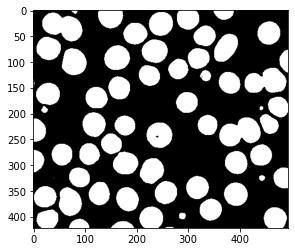

In [4]:
img, threshold = Otsu("./c1.jpg")
plt.imshow(img,"gray")

In [46]:
# HSV thresholding
def HSV_threshold(image_name):
    image = cv2.imread(image_name)
    # This select BGR2HSV
    # The following operation will be done in HSV space
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    # HSV with 3 channel which is a m * n * 3 matrix(you can check the following source in English)
    # Source: https://ww2.mathworks.cn/help/matlab/ref/hsv2rgb.html
    hsv_1st_dimension = hsv[:,:,0]
    # This is to check the hsv format which is (422, 494, 3)
    # We need to cut the (422,494)
    # print(hsv.shape)
    # print(hsv.shape[:2])
    new_hsv_shape = hsv.shape[:2]
    # Do the reshape for HSV
    new_hsv = hsv_1st_dimension.reshape(new_hsv_shape)
    # print(hsv_1st_dimension)

    # A error do not forget the shape
    height, width = new_hsv.shape
     
    # This is for the HSV thresholding result
    gray_img = np.zeros_like(new_hsv)

    # Basic is purple which is h[125,155] s[43,255] v[46,255]
    # Current the best without small cell h[125,165] s[43,255] v[46,255]
    # can find small cell h[125,170] s[43,255] v[46,255]
    # current the best with small cell h[125, 170] s[42, 255] v[46, 255]
    hue_threshold = (125, 170)
    saturation_threshold = (42, 255)
    value_threshold = (46, 255)

    # Doing the threshold
    # This HSV threshold is based on the dimension in the hsv matrix
    # Filter hue layer then saturation layer then value layer
    for h in range(height):
        for w in range(width):
            # check the whether the hue is in the range of threshold
            if hsv[h,w,0] in range(*hue_threshold):
                # check the whether the saturation is in the range of threshold
                if hsv[h,w,1] in range(*saturation_threshold):
                    # check the whether the value is in the range of threshold
                    if hsv[h,w,2] in range(*value_threshold):
                        gray_img[h,w] = 255
            else:
                gray_img[h,w] = 0
    return gray_img,hue_threshold,saturation_threshold,value_threshold

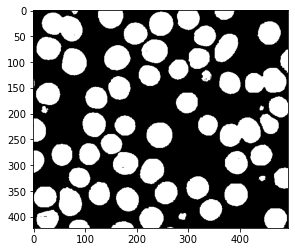

In [47]:
img, h_threshold, s_threshold, v_threshold = HSV_threshold("c1.jpg")
plt.imshow(img,"gray")